In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [77]:
ddir = '/swot/SUM02/as4479/POP_nn_predictions/'

In [80]:
ds = xr.open_mfdataset(ddir+'*.nc', chunks={'time': 1})
ds

<xarray.Dataset>
Dimensions:   (nlat: 2400, nlon: 3600, time: 365)
Coordinates:
  * nlon      (nlon) int64 0 1 2 3 4 5 6 ... 3593 3594 3595 3596 3597 3598 3599
  * nlat      (nlat) int64 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * time      (time) datetime64[ns] 1951-01-01 1951-01-02 ... 1951-12-31
Data variables:
    mask_tot  (time, nlat, nlon) bool dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    mask_lat  (time, nlat, nlon) bool dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    mask_geo  (time, nlat, nlon) bool dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    u_t_um    (time, nlat, nlon) float32 dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    v_t_um    (time, nlat, nlon) float32 dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    u_n_um    (time, nlat, nlon) float32 dask.array<shape=(365, 2400, 3600), chunksize=(1, 2400, 3600)>
    v_n_um    (time, nlat, nlon) float32 dask.array<shap

In [79]:
def mean_abs_error(a,b):
    mae=(np.abs(a-b)).mean(axis=(1,2))
    return mae
def bias(a,b):
    bias = a.mean(axis=(1,2)) -b.mean(axis=(1,2))
    return bias
def mean_square_error(a,b):
    mse = ((a-b)**2).mean(axis=(1,2))
    return mse
def root_mean_square_error(a,b):
    rmse = np.sqrt(((a-b)**2).mean(axis=(1,2)))
    return rmse
def mean_abs_error_2(u1,v1,u2,v2):
    mae = (np.abs(u2-u1) + np.abs(v2-v1)).mean(axis=(1,2))
    return mae

def mean_square_error_2(u1,v1,u2,v2):
    mse = ((u2-u1)**2+(v2-v1)**2).mean(axis=(1,2))
    return mse
def root_mean_square_error_2(u1,v1,u2,v2):
    rmse = np.sqrt(((u2-u1)**2+(v2-v1)**2).mean(axis=(1,2)))
    return rmse

def angle_diff(u1,v1,u2,v2):
    theta =(np.arccos((u1*u2 + v1*v2)/(np.sqrt(u1**2+v1**2)*np.sqrt(u2**2+v2**2)))).mean(axis=(1,2))
    return theta


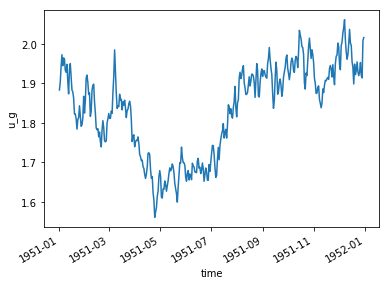

In [17]:
ds.u_g.mean(axis=(1,2)).plot()

In [45]:
Err = {}
Err['MAE_tot_n'] = mean_abs_error_2(ds.u_n,ds.v_n, ds.u_t, ds.v_t)
Err['MAE_tot_ge'] = mean_abs_error_2(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t)
Err['MAE_tot_g'] = mean_abs_error_2(ds.u_g,ds.v_g, ds.u_t, ds.v_t)
Err['MSE_tot_n'] = mean_square_error_2(ds.u_n,ds.v_n, ds.u_t, ds.v_t)
Err['MSE_tot_ge'] = mean_square_error_2(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t)
Err['MSE_tot_g'] = mean_square_error_2(ds.u_g,ds.v_g, ds.u_t, ds.v_t)

Err['angle_n'] = angle_diff(ds.u_n,ds.v_n, ds.u_t, ds.v_t)
Err['angle_ge'] = angle_diff(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t)
Err['angle_g'] = angle_diff(ds.u_g,ds.v_g, ds.u_t, ds.v_t)


In [46]:
Err['MAE_u_n'] = mean_abs_error(ds.u_n, ds.u_t)
Err['MAE_v_n'] = mean_abs_error(ds.v_n, ds.v_t)
Err['MAE_u_ge'] = mean_abs_error(ds.u_ge, ds.u_t)
Err['MAE_v_ge'] = mean_abs_error(ds.v_ge, ds.v_t)
Err['MAE_u_g'] = mean_abs_error(ds.u_g, ds.u_t)
Err['MAE_v_g'] = mean_abs_error(ds.v_g, ds.v_t)

Err['MSE_u_n'] = mean_square_error(ds.u_n, ds.u_t)
Err['MSE_v_n'] = mean_square_error(ds.v_n, ds.v_t)
Err['MSE_u_ge'] = mean_square_error(ds.u_ge, ds.u_t)
Err['MSE_v_ge'] = mean_square_error(ds.v_ge, ds.v_t)
Err['MSE_u_g'] = mean_square_error(ds.u_g, ds.u_t)
Err['MSE_v_g'] = mean_square_error(ds.v_g, ds.v_t)

Err['bias_u_n'] = bias(ds.u_n, ds.u_t)
Err['bias_v_n'] = bias(ds.v_n, ds.v_t)
Err['bias_u_ge'] = bias(ds.u_ge, ds.u_t)
Err['bias_v_ge'] = bias(ds.v_ge, ds.v_t)
Err['bias_u_g'] = bias(ds.u_g, ds.u_t)
Err['bias_v_g'] = bias(ds.v_g, ds.v_t)

In [73]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 18, 'axes.labelsize' : 11,
      'legend.fontsize' : 11,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (12.,4.)


In [43]:
figdir = 'Figs_NN/'

In [83]:
KE = {}
KE['n'] = ((0.5*(ds.u_n**2 + ds.v_n**2)).mean(axis=(1,2))).load()
KE['ge'] = ((0.5*(ds.u_ge**2 + ds.v_ge**2)).mean(axis=(1,2))).load()
KE['g'] = ((0.5*(ds.u_g**2 + ds.v_g**2)).mean(axis=(1,2))).load()
KE['t'] = ((0.5*(ds.u_t**2 + ds.v_t**2)).mean(axis=(1,2))).load()


In [81]:
Err = {}
Err['MAE_tot_n'] = mean_abs_error_2(ds.u_n,ds.v_n, ds.u_t, ds.v_t).load()
Err['MAE_tot_ge'] = mean_abs_error_2(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t).load()
Err['MAE_tot_g'] = mean_abs_error_2(ds.u_g,ds.v_g, ds.u_t, ds.v_t).load()
Err['MSE_tot_n'] = mean_square_error_2(ds.u_n,ds.v_n, ds.u_t, ds.v_t).load()
Err['MSE_tot_ge'] = mean_square_error_2(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t).load()
Err['MSE_tot_g'] = mean_square_error_2(ds.u_g,ds.v_g, ds.u_t, ds.v_t).load()

Err['angle_n'] = angle_diff(ds.u_n,ds.v_n, ds.u_t, ds.v_t).load()
Err['angle_ge'] = angle_diff(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t).load()
Err['angle_g'] = angle_diff(ds.u_g,ds.v_g, ds.u_t, ds.v_t).load()

Err['MAE_u_n'] = mean_abs_error(ds.u_n, ds.u_t)
Err['MAE_v_n'] = mean_abs_error(ds.v_n, ds.v_t)
Err['MAE_u_ge'] = mean_abs_error(ds.u_ge, ds.u_t)
Err['MAE_v_ge'] = mean_abs_error(ds.v_ge, ds.v_t)
Err['MAE_u_g'] = mean_abs_error(ds.u_g, ds.u_t)
Err['MAE_v_g'] = mean_abs_error(ds.v_g, ds.v_t)

Err['MSE_u_n'] = mean_square_error(ds.u_n, ds.u_t)
Err['MSE_v_n'] = mean_square_error(ds.v_n, ds.v_t)
Err['MSE_u_ge'] = mean_square_error(ds.u_ge, ds.u_t)
Err['MSE_v_ge'] = mean_square_error(ds.v_ge, ds.v_t)
Err['MSE_u_g'] = mean_square_error(ds.u_g, ds.u_t)
Err['MSE_v_g'] = mean_square_error(ds.v_g, ds.v_t)

Err['bias_u_n'] = bias(ds.u_n, ds.u_t).load()
Err['bias_v_n'] = bias(ds.v_n, ds.v_t).load()
Err['bias_u_ge'] = bias(ds.u_ge, ds.u_t).load()
Err['bias_v_ge'] = bias(ds.v_ge, ds.v_t).load()
Err['bias_u_g'] = bias(ds.u_g, ds.u_t).load()
Err['bias_v_g'] = bias(ds.v_g, ds.v_t).load()


/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in arccos
  return func(*args2)


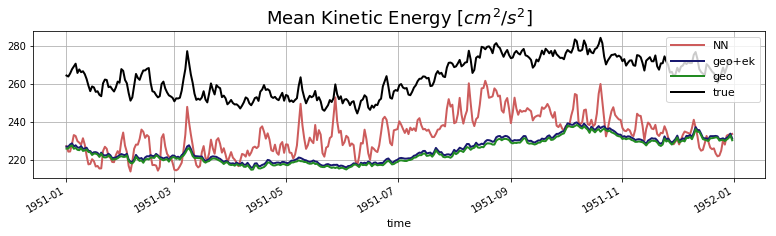

In [93]:
fig = plt.figure(figsize=(11,3.5))
KE['n'].plot(color = 'indianred',linewidth=2,label='NN')
KE['ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
KE['g'].plot(color = 'forestgreen',linewidth=2,label='geo')
KE['t'].plot(color = 'k',linewidth=2,label='true')
plt.legend(loc=1)
plt.title(r'Mean Kinetic Energy [$cm^2/s^2$]')
plt.grid()
#plt.xlabel('')


plt.tight_layout()

fig.savefig(figdir+'KE_global_timeseries.pdf')

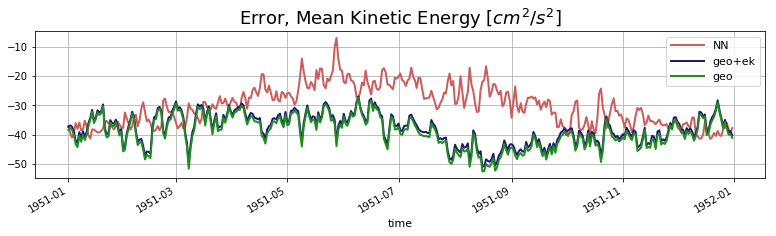

In [94]:
fig = plt.figure(figsize=(11,3.5))
(KE['n']-KE['t']).plot(color = 'indianred',linewidth=2,label='NN')
(KE['ge']-KE['t']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
(KE['g']-KE['t']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Mean Kinetic Energy [$cm^2/s^2$]')
plt.grid()
#plt.xlabel('')


plt.tight_layout()

fig.savefig(figdir+'KE_error_global_timeseries.pdf')

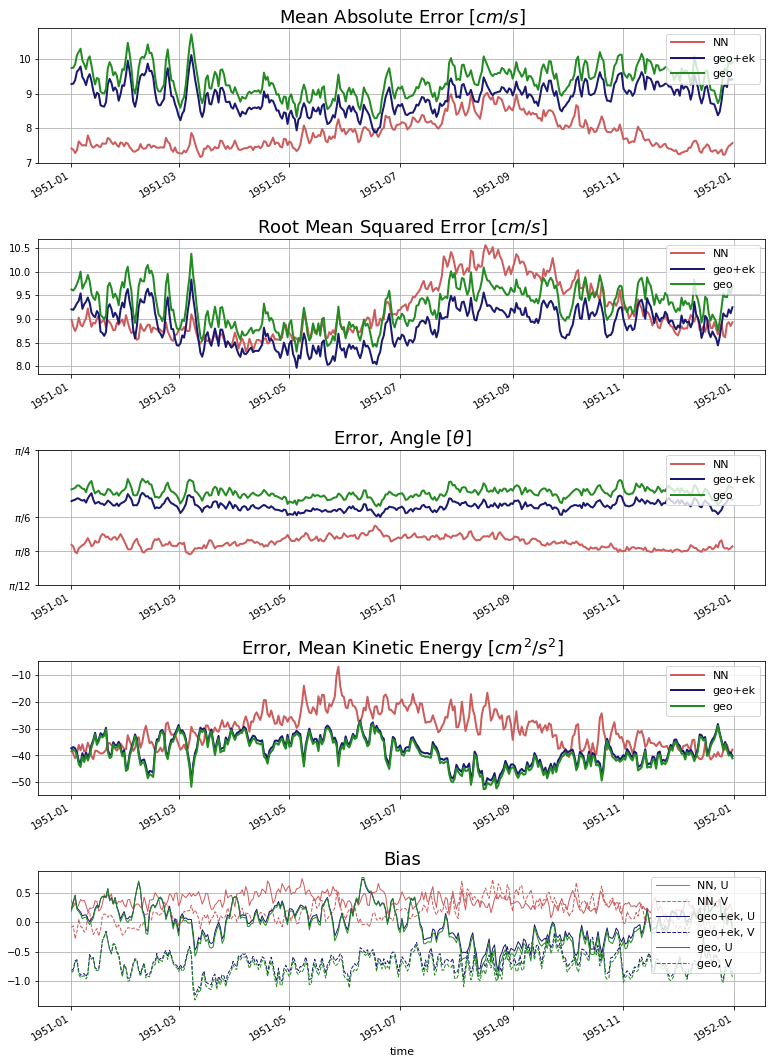

In [91]:
fig = plt.figure(figsize=(11,15))
plt.subplot(511)
Err['MAE_tot_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['MAE_tot_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['MAE_tot_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Mean Absolute Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(512)
np.sqrt(Err['MSE_tot_n']).plot(color = 'indianred',linewidth=2,label='NN')
np.sqrt(Err['MSE_tot_ge']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
np.sqrt(Err['MSE_tot_g']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Root Mean Squared Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(513)
Err['angle_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['angle_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['angle_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Angle [$\theta$]')
plt.yticks([np.pi/12,np.pi/8, np.pi/6, np.pi/4],[r'$\pi/12$',r'$\pi/8$',r'$\pi/6$',r'$\pi/4$'])
plt.grid()
plt.xlabel('')

plt.subplot(514)
(KE['n']-KE['t']).plot(color = 'indianred',linewidth=2,label='NN')
(KE['ge']-KE['t']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
(KE['g']-KE['t']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Mean Kinetic Energy [$cm^2/s^2$]')
plt.grid()
plt.xlabel('')


plt.subplot(515)
Err['bias_u_n'].plot(linewidth=1,color = 'indianred',label='NN, U')
Err['bias_v_n'].plot(linewidth=1,color = 'indianred',linestyle='dashed',label='NN, V')

Err['bias_u_ge'].plot(linewidth=1,color = 'midnightblue',label='geo+ek, U')
Err['bias_v_ge'].plot(linewidth=1,color = 'midnightblue',linestyle='dashed',label='geo+ek, V')

Err['bias_u_g'].plot(linewidth=1,color = 'forestgreen',label='geo, U')
Err['bias_v_g'].plot(linewidth=1,color = 'forestgreen',linestyle='dashed',label='geo, V')
plt.legend(loc=1)
plt.grid()
plt.title('Bias')
plt.tight_layout()

fig.savefig(figdir+'Errors_wKE_global_timeseries.pdf')

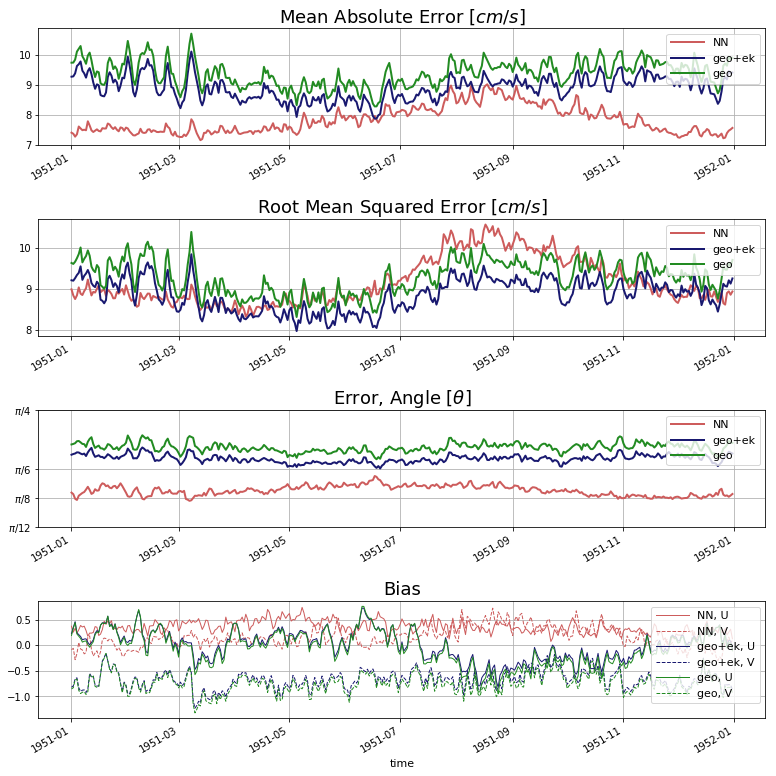

In [85]:
fig = plt.figure(figsize=(11,11))
plt.subplot(411)
Err['MAE_tot_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['MAE_tot_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['MAE_tot_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Mean Absolute Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(412)
np.sqrt(Err['MSE_tot_n']).plot(color = 'indianred',linewidth=2,label='NN')
np.sqrt(Err['MSE_tot_ge']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
np.sqrt(Err['MSE_tot_g']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Root Mean Squared Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(413)
Err['angle_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['angle_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['angle_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Angle [$\theta$]')
plt.yticks([np.pi/12,np.pi/8, np.pi/6, np.pi/4],[r'$\pi/12$',r'$\pi/8$',r'$\pi/6$',r'$\pi/4$'])
plt.grid()
plt.xlabel('')

plt.subplot(414)
Err['bias_u_n'].plot(linewidth=1,color = 'indianred',label='NN, U')
Err['bias_v_n'].plot(linewidth=1,color = 'indianred',linestyle='dashed',label='NN, V')

Err['bias_u_ge'].plot(linewidth=1,color = 'midnightblue',label='geo+ek, U')
Err['bias_v_ge'].plot(linewidth=1,color = 'midnightblue',linestyle='dashed',label='geo+ek, V')

Err['bias_u_g'].plot(linewidth=1,color = 'forestgreen',label='geo, U')
Err['bias_v_g'].plot(linewidth=1,color = 'forestgreen',linestyle='dashed',label='geo, V')
plt.legend(loc=1)
plt.grid()
plt.title('Bias')

plt.tight_layout()

fig.savefig(figdir+'Errors_global_timeseries.pdf')

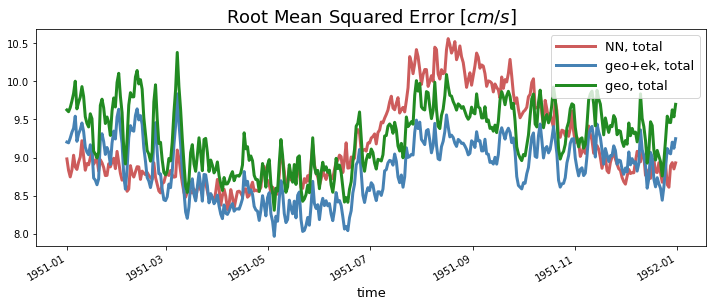

In [53]:
fig = plt.figure()
np.sqrt(Err['MSE_tot_n']).plot(color = 'indianred',linewidth=3,label='NN, total')
np.sqrt(Err['MSE_tot_ge']).plot(color = 'steelblue',linewidth=3,label='geo+ek, total')
np.sqrt(Err['MSE_tot_g']).plot(color = 'forestgreen',linewidth=3,label='geo, total')
plt.legend(loc=0)
plt.title(r'Root Mean Squared Error [$cm/s$]')
fig.savefig(figdir+'RMSE_globe_timeseries.pdf')

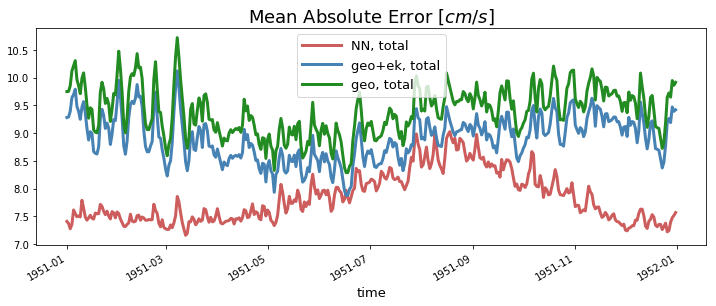

In [52]:
fig = plt.figure()
Err['MAE_tot_n'].plot(color = 'indianred',linewidth=3,label='NN, total')
Err['MAE_tot_ge'].plot(color = 'steelblue',linewidth=3,label='geo+ek, total')
Err['MAE_tot_g'].plot(color = 'forestgreen',linewidth=3,label='geo, total')
plt.legend(loc=0)
plt.title(r'Mean Absolute Error [$cm/s$]')
fig.savefig(figdir+'MAE_globe_timeseries.pdf')

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in arccos
  return func(*args2)


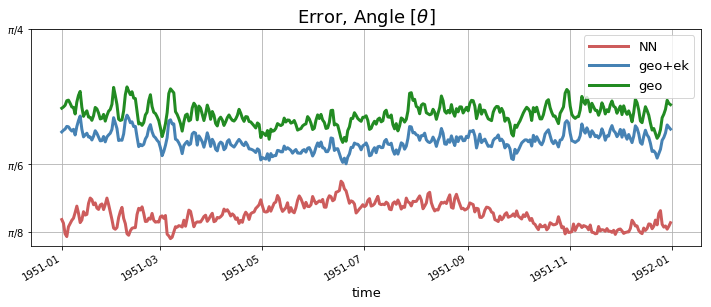

In [55]:
fig = plt.figure()
Err['angle_n'].plot(color = 'indianred',linewidth=3,label='NN')
Err['angle_ge'].plot(color = 'steelblue',linewidth=3,label='geo+ek')
Err['angle_g'].plot(color = 'forestgreen',linewidth=3,label='geo')
plt.legend(loc=0)
plt.title(r'Error, Angle [$\theta$]')
plt.yticks([np.pi/8, np.pi/6, np.pi/4],[r'$\pi/8$',r'$\pi/6$',r'$\pi/4$'])
#plt.yticklabels([r'$\pi/8$',r'$\pi/6$',r'$\pi/4$'])
plt.grid()
fig.savefig(figdir+'Angle_globe_timeseries.pdf')

Text(0.5, 1.0, 'Mean Absolute Error [$cm/s$]')

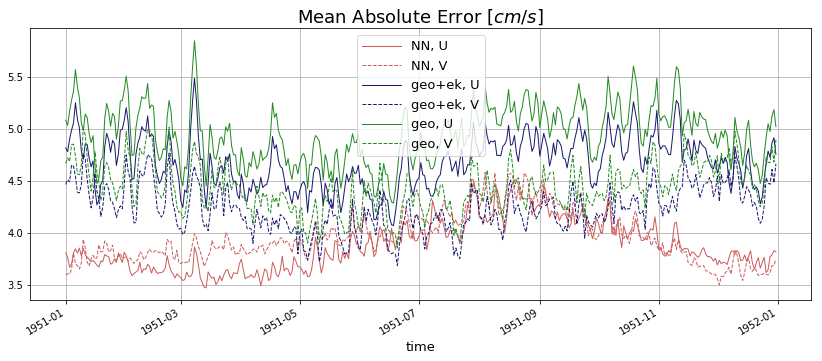

In [39]:
Err['MAE_u_n'].plot(linewidth=1,color = 'indianred',label='NN, U')
Err['MAE_v_n'].plot(linewidth=1,color = 'indianred',linestyle='dashed',label='NN, V')

Err['MAE_u_ge'].plot(linewidth=1,color = 'midnightblue',label='geo+ek, U')
Err['MAE_v_ge'].plot(linewidth=1,color = 'midnightblue',linestyle='dashed',label='geo+ek, V')

Err['MAE_u_g'].plot(linewidth=1,color = 'forestgreen',label='geo, U')
Err['MAE_v_g'].plot(linewidth=1,color = 'forestgreen',linestyle='dashed',label='geo, V')

plt.legend(loc=0)
plt.grid()
plt.title(r'Mean Absolute Error [$cm/s$]')

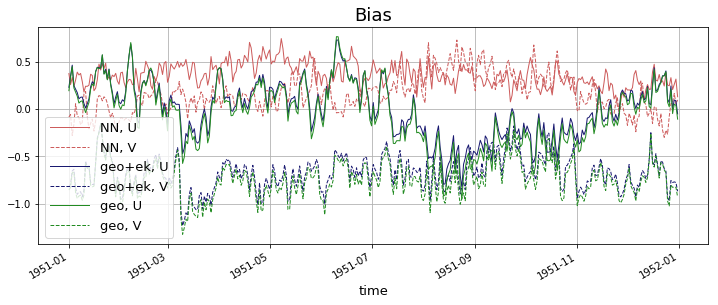

In [54]:
fig = plt.figure()
Err['bias_u_n'].plot(linewidth=1,color = 'indianred',label='NN, U')
Err['bias_v_n'].plot(linewidth=1,color = 'indianred',linestyle='dashed',label='NN, V')

Err['bias_u_ge'].plot(linewidth=1,color = 'midnightblue',label='geo+ek, U')
Err['bias_v_ge'].plot(linewidth=1,color = 'midnightblue',linestyle='dashed',label='geo+ek, V')

Err['bias_u_g'].plot(linewidth=1,color = 'forestgreen',label='geo, U')
Err['bias_v_g'].plot(linewidth=1,color = 'forestgreen',linestyle='dashed',label='geo, V')
plt.legend(loc=0)
plt.grid()
plt.title('Bias')
fig.savefig(figdir+'Bias_globe_timeseries.pdf')

In [123]:
ds = ds.isel(nlat=slice(200,1000))
ds['u_ge2'] = ds.u_g + np.sqrt(10)*ds.u_e
ds['v_ge2'] = ds.v_g + np.sqrt(10)*ds.v_e


In [124]:
Err = {}
Err['MAE_tot_n'] = mean_abs_error_2(ds.u_n,ds.v_n, ds.u_t, ds.v_t).load()
#Err['MAE_tot_ge'] = mean_abs_error_2(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t).load()
Err['MAE_tot_ge'] = mean_abs_error_2(ds.u_ge2,ds.v_ge2, ds.u_t, ds.v_t).load()
Err['MAE_tot_g'] = mean_abs_error_2(ds.u_g,ds.v_g, ds.u_t, ds.v_t).load()
Err['MSE_tot_n'] = mean_square_error_2(ds.u_n,ds.v_n, ds.u_t, ds.v_t).load()
#Err['MSE_tot_ge'] = mean_square_error_2(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t).load()
Err['MSE_tot_ge'] = mean_square_error_2(ds.u_ge2,ds.v_ge2, ds.u_t, ds.v_t).load()
Err['MSE_tot_g'] = mean_square_error_2(ds.u_g,ds.v_g, ds.u_t, ds.v_t).load()

Err['angle_n'] = angle_diff(ds.u_n,ds.v_n, ds.u_t, ds.v_t).load()
#Err['angle_ge'] = angle_diff(ds.u_ge,ds.v_ge, ds.u_t, ds.v_t).load()
Err['angle_ge'] = angle_diff(ds.u_ge2,ds.v_ge2, ds.u_t, ds.v_t).load()
Err['angle_g'] = angle_diff(ds.u_g,ds.v_g, ds.u_t, ds.v_t).load()

Err['bias_u_n'] = bias(ds.u_n, ds.u_t).load()
Err['bias_v_n'] = bias(ds.v_n, ds.v_t).load()
#Err['bias_u_ge'] = bias(ds.u_ge, ds.u_t).load()
#Err['bias_v_ge'] = bias(ds.v_ge, ds.v_t).load()
Err['bias_u_ge'] = bias(ds.u_ge2, ds.u_t).load()
Err['bias_v_ge'] = bias(ds.v_ge2, ds.v_t).load()

Err['bias_u_g'] = bias(ds.u_g, ds.u_t).load()
Err['bias_v_g'] = bias(ds.v_g, ds.v_t).load()


/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in arccos
  return func(*args2)


In [125]:
KE = {}
KE['n'] = ((0.5*(ds.u_n**2 + ds.v_n**2)).mean(axis=(1,2))).load()
#KE['ge'] = ((0.5*(ds.u_ge**2 + ds.v_ge**2)).mean(axis=(1,2))).load()
KE['ge'] = ((0.5*(ds.u_ge2**2 + ds.v_ge2**2)).mean(axis=(1,2))).load()
KE['g'] = ((0.5*(ds.u_g**2 + ds.v_g**2)).mean(axis=(1,2))).load()
KE['t'] = ((0.5*(ds.u_t**2 + ds.v_t**2)).mean(axis=(1,2))).load()


In [126]:
ds['u_n_prime'] = ds.u_n - ds.u_n.mean(dim='time')
ds['u_t_prime'] = ds.u_t - ds.u_t.mean(dim='time')
#ds['u_ge_prime'] = ds.u_ge - ds.u_ge.mean(dim='time')
ds['u_ge_prime'] = ds.u_ge2 - ds.u_ge2.mean(dim='time')
ds['u_g_prime'] = ds.u_g - ds.u_g.mean(dim='time')

ds['v_n_prime'] = ds.v_n - ds.v_n.mean(dim='time')
ds['v_t_prime'] = ds.v_t - ds.v_t.mean(dim='time')
#ds['v_ge_prime'] = ds.v_ge - ds.v_ge.mean(dim='time')
ds['v_ge_prime'] = ds.v_ge2 - ds.v_ge2.mean(dim='time')
ds['v_g_prime'] = ds.v_g - ds.v_g.mean(dim='time')


In [127]:
KE['n_prime'] = ((0.5*(ds.u_n_prime**2 + ds.v_n_prime**2)).mean(axis=(1,2))).load()
KE['ge_prime'] = ((0.5*(ds.u_ge_prime**2 + ds.v_ge_prime**2)).mean(axis=(1,2))).load()
KE['g_prime'] = ((0.5*(ds.u_g_prime**2 + ds.v_g_prime**2)).mean(axis=(1,2))).load()
KE['t_prime'] = ((0.5*(ds.u_t_prime**2 + ds.v_t_prime**2)).mean(axis=(1,2))).load()


/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


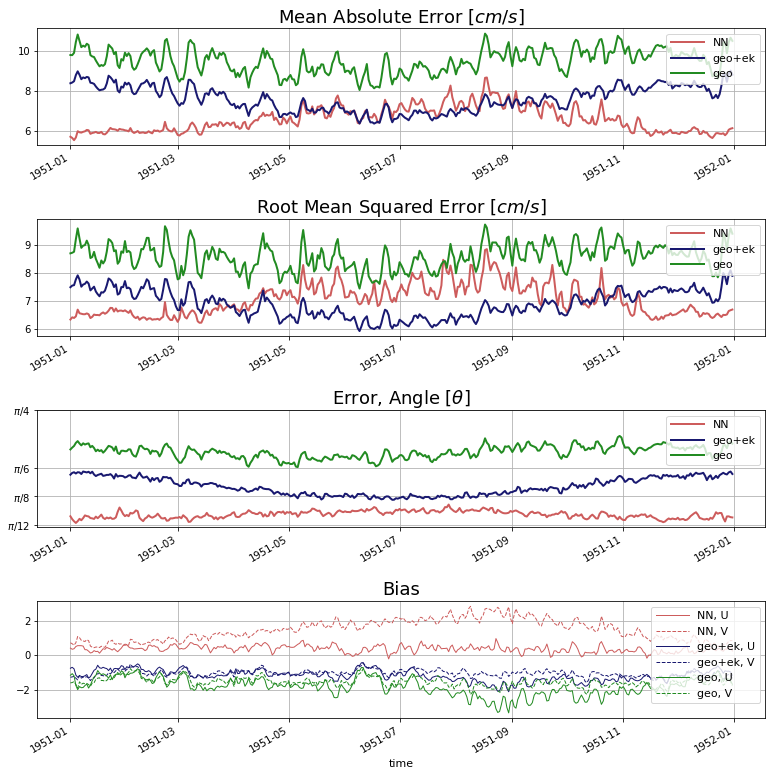

In [128]:
fig = plt.figure(figsize=(11,11))
plt.subplot(411)
Err['MAE_tot_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['MAE_tot_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['MAE_tot_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Mean Absolute Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(412)
np.sqrt(Err['MSE_tot_n']).plot(color = 'indianred',linewidth=2,label='NN')
np.sqrt(Err['MSE_tot_ge']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
np.sqrt(Err['MSE_tot_g']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Root Mean Squared Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(413)
Err['angle_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['angle_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['angle_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Angle [$\theta$]')
plt.yticks([np.pi/12,np.pi/8, np.pi/6, np.pi/4],[r'$\pi/12$',r'$\pi/8$',r'$\pi/6$',r'$\pi/4$'])
plt.grid()
plt.xlabel('')

plt.subplot(414)
Err['bias_u_n'].plot(linewidth=1,color = 'indianred',label='NN, U')
Err['bias_v_n'].plot(linewidth=1,color = 'indianred',linestyle='dashed',label='NN, V')

Err['bias_u_ge'].plot(linewidth=1,color = 'midnightblue',label='geo+ek, U')
Err['bias_v_ge'].plot(linewidth=1,color = 'midnightblue',linestyle='dashed',label='geo+ek, V')

Err['bias_u_g'].plot(linewidth=1,color = 'forestgreen',label='geo, U')
Err['bias_v_g'].plot(linewidth=1,color = 'forestgreen',linestyle='dashed',label='geo, V')
plt.legend(loc=1)
plt.grid()
plt.title('Bias')

plt.tight_layout()

fig.savefig(figdir+'Errors_SO_timeseries.pdf')

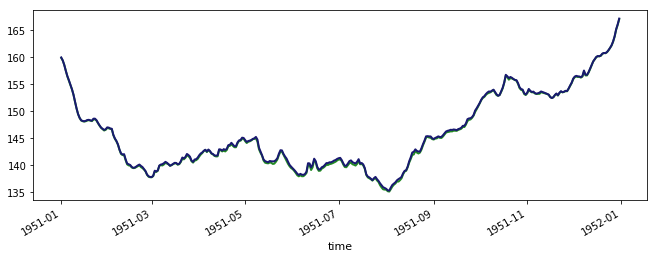

In [122]:
fig = plt.figure(figsize=(11,3.5))
#KE['n_prime'].plot(color = 'indianred',linewidth=2,label='NN')
KE['g_prime'].plot(color = 'forestgreen',linewidth=2,label='geo')
KE['ge_prime'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')


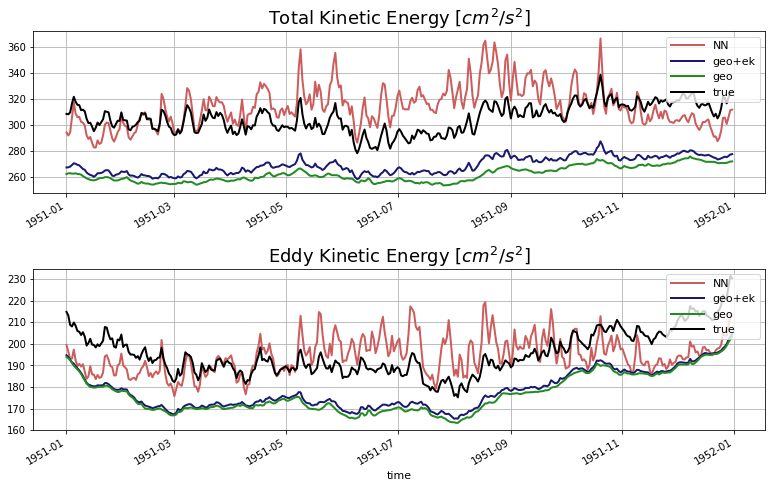

In [129]:
fig = plt.figure(figsize=(11,7))
plt.subplot(211)
KE['n'].plot(color = 'indianred',linewidth=2,label='NN')
KE['ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
KE['g'].plot(color = 'forestgreen',linewidth=2,label='geo')
KE['t'].plot(color = 'k',linewidth=2,label='true')
plt.legend(loc=1)
plt.title(r'Total Kinetic Energy [$cm^2/s^2$]')
plt.grid()
plt.xlabel('')
plt.subplot(212)

KE['n_prime'].plot(color = 'indianred',linewidth=2,label='NN')
KE['ge_prime'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
KE['g_prime'].plot(color = 'forestgreen',linewidth=2,label='geo')
KE['t_prime'].plot(color = 'k',linewidth=2,label='true')
plt.legend(loc=1)
plt.title(r'Eddy Kinetic Energy [$cm^2/s^2$]')
plt.grid()
#plt.xlabel('')


plt.tight_layout()

fig.savefig(figdir+'KE_EKE_SO_timeseries.pdf')

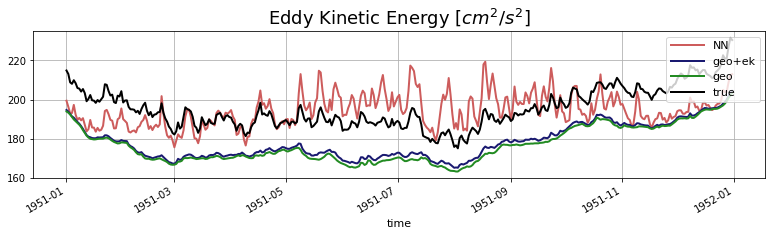

In [130]:
fig = plt.figure(figsize=(11,3.5))
KE['n_prime'].plot(color = 'indianred',linewidth=2,label='NN')
KE['ge_prime'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
KE['g_prime'].plot(color = 'forestgreen',linewidth=2,label='geo')
KE['t_prime'].plot(color = 'k',linewidth=2,label='true')
plt.legend(loc=1)
plt.title(r'Eddy Kinetic Energy [$cm^2/s^2$]')
plt.grid()
#plt.xlabel('')


plt.tight_layout()

fig.savefig(figdir+'EKE_SO_timeseries.pdf')

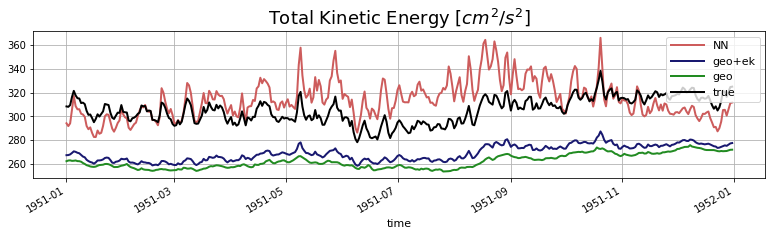

In [131]:
fig = plt.figure(figsize=(11,3.5))
KE['n'].plot(color = 'indianred',linewidth=2,label='NN')
KE['ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
KE['g'].plot(color = 'forestgreen',linewidth=2,label='geo')
KE['t'].plot(color = 'k',linewidth=2,label='true')
plt.legend(loc=1)
plt.title(r'Total Kinetic Energy [$cm^2/s^2$]')
plt.grid()
#plt.xlabel('')


plt.tight_layout()

fig.savefig(figdir+'KE_SO_timeseries.pdf')

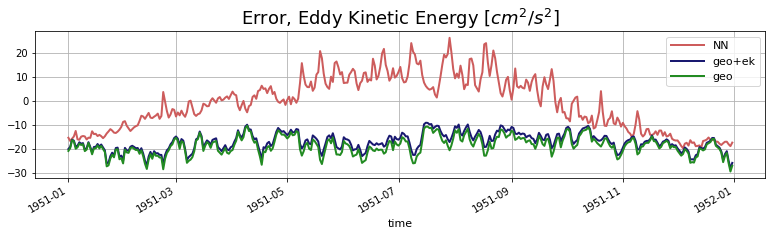

In [132]:
fig = plt.figure(figsize=(11,3.5))
(KE['n_prime']-KE['t_prime']).plot(color = 'indianred',linewidth=2,label='NN')
(KE['ge_prime']-KE['t_prime']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
(KE['g_prime']-KE['t_prime']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Eddy Kinetic Energy [$cm^2/s^2$]')
plt.grid()
#plt.xlabel('')


plt.tight_layout()

fig.savefig(figdir+'EKE_error_SO_timeseries.pdf')

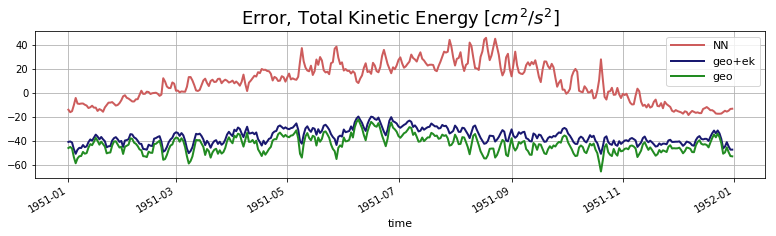

In [133]:
fig = plt.figure(figsize=(11,3.5))
(KE['n']-KE['t']).plot(color = 'indianred',linewidth=2,label='NN')
(KE['ge']-KE['t']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
(KE['g']-KE['t']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Total Kinetic Energy [$cm^2/s^2$]')
plt.grid()
#plt.xlabel('')


plt.tight_layout()

fig.savefig(figdir+'KE_error_SO_timeseries.pdf')

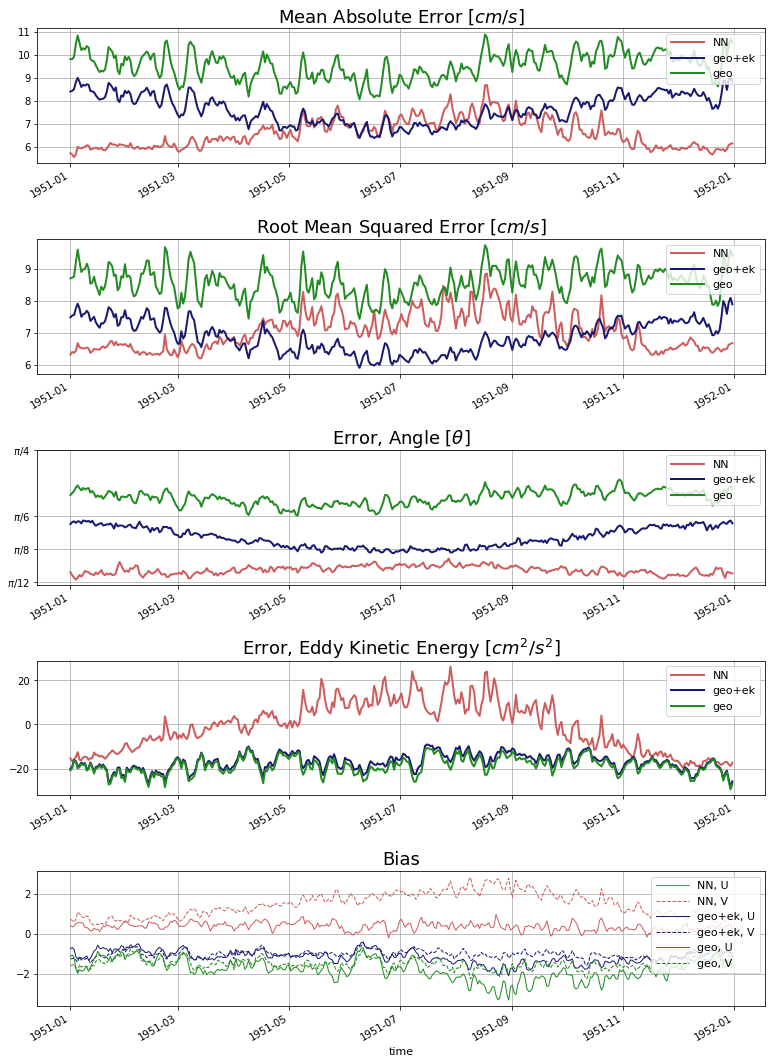

In [134]:
fig = plt.figure(figsize=(11,15))
plt.subplot(511)
Err['MAE_tot_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['MAE_tot_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['MAE_tot_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Mean Absolute Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(512)
np.sqrt(Err['MSE_tot_n']).plot(color = 'indianred',linewidth=2,label='NN')
np.sqrt(Err['MSE_tot_ge']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
np.sqrt(Err['MSE_tot_g']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Root Mean Squared Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(513)
Err['angle_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['angle_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['angle_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Angle [$\theta$]')
plt.yticks([np.pi/12,np.pi/8, np.pi/6, np.pi/4],[r'$\pi/12$',r'$\pi/8$',r'$\pi/6$',r'$\pi/4$'])
plt.grid()
plt.xlabel('')

plt.subplot(514)
(KE['n_prime']-KE['t_prime']).plot(color = 'indianred',linewidth=2,label='NN')
(KE['ge_prime']-KE['t_prime']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
(KE['g_prime']-KE['t_prime']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Eddy Kinetic Energy [$cm^2/s^2$]')
plt.grid()
plt.xlabel('')


plt.subplot(515)
Err['bias_u_n'].plot(linewidth=1,color = 'indianred',label='NN, U')
Err['bias_v_n'].plot(linewidth=1,color = 'indianred',linestyle='dashed',label='NN, V')

Err['bias_u_ge'].plot(linewidth=1,color = 'midnightblue',label='geo+ek, U')
Err['bias_v_ge'].plot(linewidth=1,color = 'midnightblue',linestyle='dashed',label='geo+ek, V')

Err['bias_u_g'].plot(linewidth=1,color = 'forestgreen',label='geo, U')
Err['bias_v_g'].plot(linewidth=1,color = 'forestgreen',linestyle='dashed',label='geo, V')
plt.legend(loc=1)
plt.grid()
plt.title('Bias')
plt.tight_layout()

fig.savefig(figdir+'Errors_wEKE_SO_timeseries.pdf')

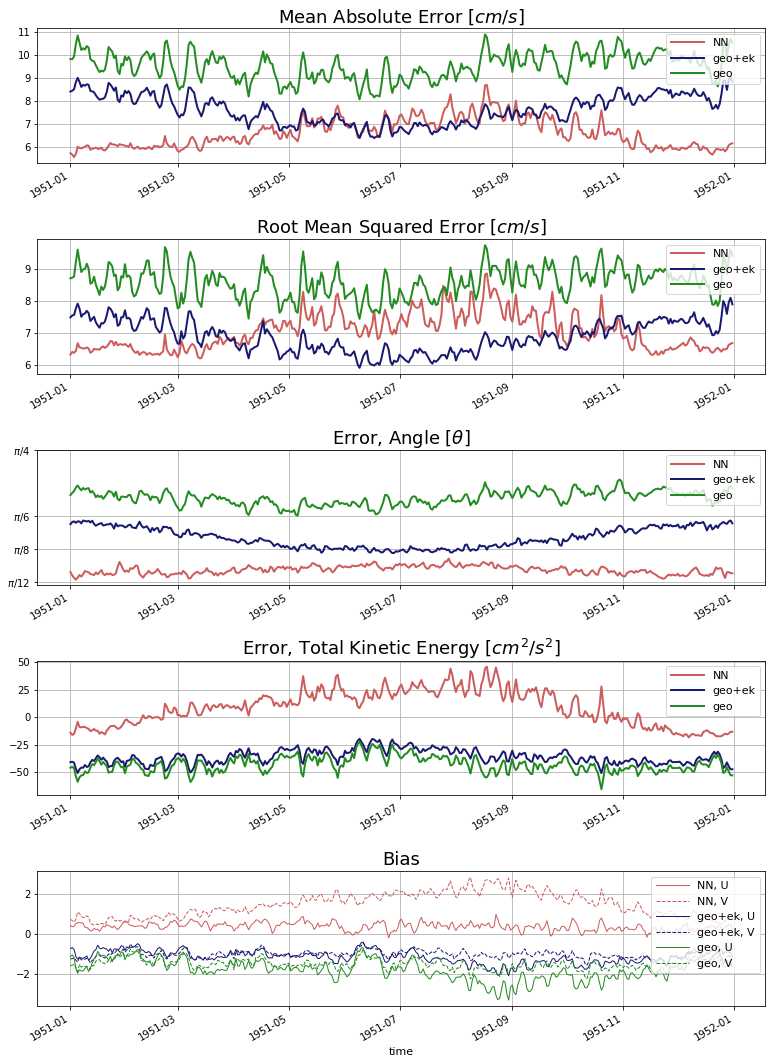

In [135]:
fig = plt.figure(figsize=(11,15))
plt.subplot(511)
Err['MAE_tot_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['MAE_tot_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['MAE_tot_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Mean Absolute Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(512)
np.sqrt(Err['MSE_tot_n']).plot(color = 'indianred',linewidth=2,label='NN')
np.sqrt(Err['MSE_tot_ge']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
np.sqrt(Err['MSE_tot_g']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Root Mean Squared Error [$cm/s$]')
plt.grid()
plt.xlabel('')

plt.subplot(513)
Err['angle_n'].plot(color = 'indianred',linewidth=2,label='NN')
Err['angle_ge'].plot(color = 'midnightblue',linewidth=2,label='geo+ek')
Err['angle_g'].plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Angle [$\theta$]')
plt.yticks([np.pi/12,np.pi/8, np.pi/6, np.pi/4],[r'$\pi/12$',r'$\pi/8$',r'$\pi/6$',r'$\pi/4$'])
plt.grid()
plt.xlabel('')

plt.subplot(514)
(KE['n']-KE['t']).plot(color = 'indianred',linewidth=2,label='NN')
(KE['ge']-KE['t']).plot(color = 'midnightblue',linewidth=2,label='geo+ek')
(KE['g']-KE['t']).plot(color = 'forestgreen',linewidth=2,label='geo')
plt.legend(loc=1)
plt.title(r'Error, Total Kinetic Energy [$cm^2/s^2$]')
plt.grid()
plt.xlabel('')


plt.subplot(515)
Err['bias_u_n'].plot(linewidth=1,color = 'indianred',label='NN, U')
Err['bias_v_n'].plot(linewidth=1,color = 'indianred',linestyle='dashed',label='NN, V')

Err['bias_u_ge'].plot(linewidth=1,color = 'midnightblue',label='geo+ek, U')
Err['bias_v_ge'].plot(linewidth=1,color = 'midnightblue',linestyle='dashed',label='geo+ek, V')

Err['bias_u_g'].plot(linewidth=1,color = 'forestgreen',label='geo, U')
Err['bias_v_g'].plot(linewidth=1,color = 'forestgreen',linestyle='dashed',label='geo, V')
plt.legend(loc=1)
plt.grid()
plt.title('Bias')
plt.tight_layout()

fig.savefig(figdir+'Errors_wKE_SO_timeseries.pdf')